## V5 모델의 Back 데이터 중 오분류가 발생한 데이터의 SHAP 분석 

In [122]:
import os
import glob
import torch
import numpy as np
import torchvision.transforms as transforms
import shap
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image

In [ ]:
# ResNet50 모델 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용시를 상정하여 작성
model = models.resnet50(weights=None) # 가중치 없는 모델
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3) # 클래스 3개
model.load_state_dict(torch.load(r"C:\Users\USER\Desktop\my_git\safebaby-xai\resnet50_explain\resnet50_sample_data\V5\best_model_V5.pth", map_location=device)) # 저장된 모델 불러오기기 
model.to(device)
model.eval() # 모델을 평가 모드로 전환

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 로드 및 변환 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0) # 배치 차원 추가 (1, C, H, W)
    return image_tensor.to(device) # GPU 사용 시를 상정하여 텐서를 특정 장치로 이동시키도록 .to(device)

# 모델 예측 함수
def model_forward(x):
    # SHAP explainer에 입력할 모델 예측 함수
    x_tensor = torch.tensor(x).permute(0, 3, 1, 2).to(device) # (batch, H, W, C) → (batch, C, H, W)
    with torch.no_grad():
        logits = model(x_tensor) # 모델 예측 수행 (logits 값 출력)
        probabilities = F.softmax(logits, dim=1) # 확률 값으로 변환
    return probabilities.cpu().numpy() # numpy 배열로 변환

# SHAP partition explainer 설정
# SHAP 마스킹 방식 설정 (이미지 차원: 224x224, 3)
masker = shap.maskers.Image("blur(3, 3)", (224, 224, 3))

# SHAP Explainer 정의
explainer = shap.Explainer(model_forward, masker)

# 분석할 이미지 로드 및 전처리
image_path = r"C:\Users\USER\Desktop\my_git\safebaby-xai\resnet50_explain\resnet50_sample_data\V5\back\images\b0179_dark_sr.png" # 분석할 이미지 경로 입력
image_tensor = preprocess_image(image_path).to(device)

# 클래스명 정의
class_name = ["Back", "Front", "Side"]

# 모델 예측 수행
output = model(image_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1) # 확률 변환

# 결과 출력
print("결과 : ", output)
print("예측 확률 :", probabilities)
predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted Class Index: {predicted_class} -> Class Name: {class_name[predicted_class]}")

결과 :  tensor([[ 2.5303,  2.6783, -5.4165]], grad_fn=<AddmmBackward0>)
예측 확률 : tensor([[4.6299e-01, 5.3685e-01, 1.6381e-04]], grad_fn=<SoftmaxBackward0>)
Predicted Class Index: 1 -> Class Name: Front


변환된 이미지 크기: (224, 224, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.85s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2042704].


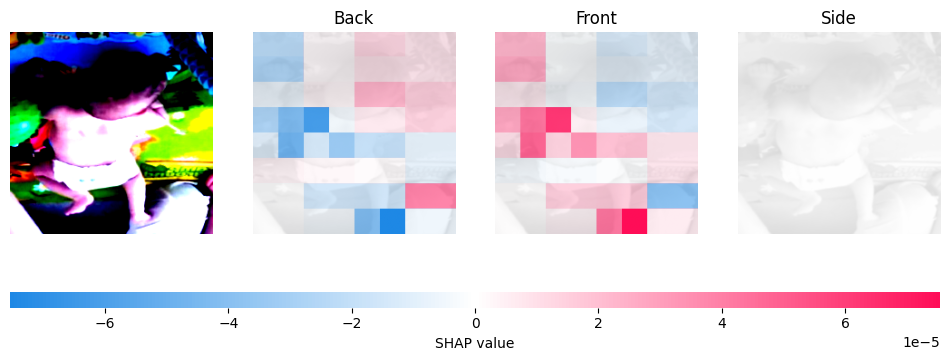

In [131]:
# 올바른 차원 변환 적용 (1, C, H, W, -> H, W, C)
image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 차원 확인
print("변환된 이미지 크기:", image_numpy.shape) # (224, 224, 3) 확인

# SHAP 값 계산
shap_values = explainer(np.expand_dims(image_numpy, axis=0), max_evals=500, batch_size=50)

# 시각화
shap.image_plot(shap_values, np.expand_dims(image_numpy, axis=0), labels=class_name)

# 배치처리

### 사전 정의
- 오분류 이미지 경로
- ResNet50 모델 불러오기
- 이미지 전처리
- 분류 클래스 명 정의
- 함수 정의
    - preprocess_image() - 이미지 변환
    - predict_class() 모델 예측
    - forward 함수 정의(SHAP 분석에 필요)
- SHAP 마스킹 정의
- 예측 클래스 저장할 리스트

In [94]:
# 오분류 이미지 경로
misclassified_path = r"C:\Users\USER\Desktop\my_git\safebaby-xai\resnet50_explain\resnet50_sample_data\V5\back\wrong_front"
image_paths = glob.glob(os.path.join(misclassified_path, "*.png"))

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None) # 가중치 없는 모델
model_path = r"resnet50_sample_data\V5\best_model_V5.pth"

# fc 확인 (3개 맞는지)
num_ftrs = model.fc.in_features
if model.fc.out_features != 3:
    model.fc = torch.nn.Linear(num_ftrs, 3) # 3아니면 출력 뉴런 3개로 변경

# V5 모델 가중치 로드
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval() # 모델을 평가 모드로 설정

# 기존 ResNet50 모델과 동일 전처리리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 클래스 정의
classes = ["Back", "Front", "Side"]

# 이미지 변환(ResNet50 입력 형식)
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0) # 배치 차원을 추가
    return image_tensor.to(device)

# 모델 예측 함수
def predict_class(img_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor) # 모델 예측값 (logits)
        probs = F.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item() # 가장 높은 확률의 클래스 선택
    return classes[pred_class], probs.cpu().numpy()

# 모델 예측 함수
def model_forward(x):
    # SHAP explainer에 입력할 모델 예측 함수
    x_tensor = torch.tensor(x).permute(0, 3, 1, 2).to(device) # (batch, H, W, C) → (batch, C, H, W)
    with torch.no_grad():
        logits = model(x_tensor) # 모델 예측 수행 (logits 값 출력)
        probabilities = F.softmax(logits, dim=1) # 확률 값으로 변환
    return probabilities.cpu().numpy() # numpy 배열로 변환

# SHAP 마스킹 설정
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))

# SHAP explainer 설정
explainer = shap.Explainer(model_forward, masker)

# 모델이 예측한 클래스 저장할 리스트
predicted_labels = []
image_tensors = []

# 각 이미지별로 모델 예측 수행 + 배치 단위 SHAP 분석을 위한 이미지 저장
for img_path in image_paths:
    img_tensor = preprocess_image(img_path)
    image_tensors.append(img_tensor)

    # 모델 예측 수행
    pred_class_name, pred_probs = predict_class(img_tensor)
    predicted_labels.append(pred_class_name)

# 배치 데이터로 변환 (SHAP)
image_tensors = torch.cat(image_tensors, dim=0)
image_array_shap = image_tensors.cpu().numpy().transpose(0, 2, 3, 1)

# SHAP explainer 실행 (batch 전체에 대해 실행)
shap_values = explainer(image_array_shap)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [00:54<00:00, 13.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:22, 27.64s/it]                       


In [79]:
# SHAP values 저장
np.save("shap_values_v5.npy", shap_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3997992343835275..1.4510041225927122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.64].


IndexError: index 1 is out of bounds for axis 0 with size 1

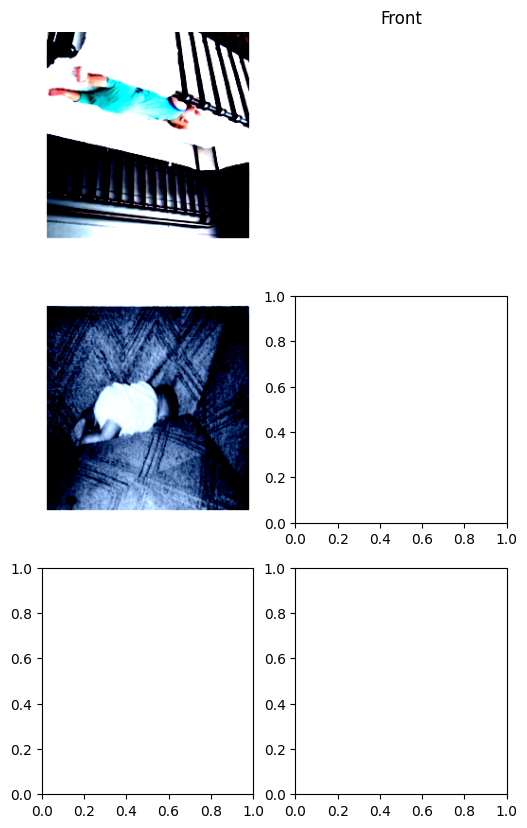

In [95]:
shap.image_plot(shap_values_fixed, image_array_shap, labels=predicted_labels)

In [75]:
# SHAP values 불러오기
shap_values = np.load("shap_values_v5.npy", allow_pickle=True)

In [76]:
print(f"✅ SHAP values range: min={shap_values_fixed.min()}, max={shap_values_fixed.max()}")


✅ SHAP values range: min=0.0, max=1.0


In [ ]:
shap_values_fixed = shap_values_fixed / np.abs(shap_values_fixed).max()  # 정규화하여 대비 향상


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3997992343835275..1.4510041225927122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4124026795935094..1.4785946479979872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4169029723935407..1.4454732891168778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255]

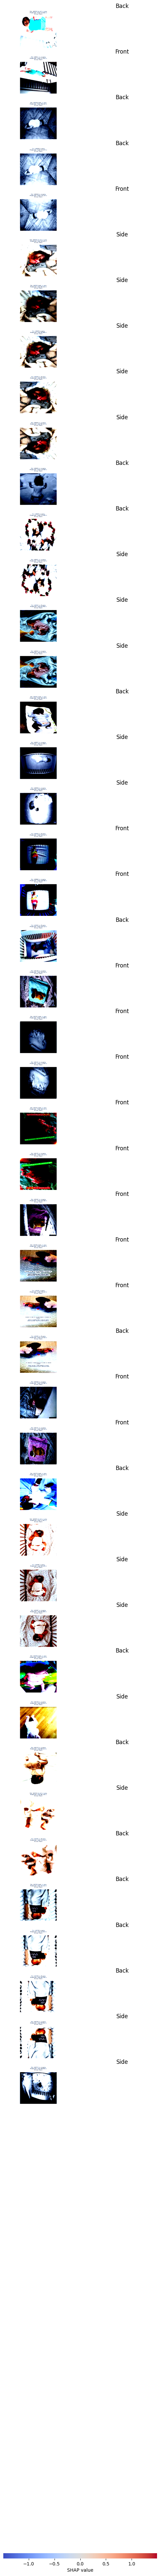

In [70]:
shap.image_plot(shap_values_fixed, image_array_shap, labels=predicted_labels, cmap="coolwarm")


✅ Fixed Labels shape: (46, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3997992343835275..1.4510041225927122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4124026795935094..1.4785946479979872].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4169029723935407..1.4454732891168778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255]

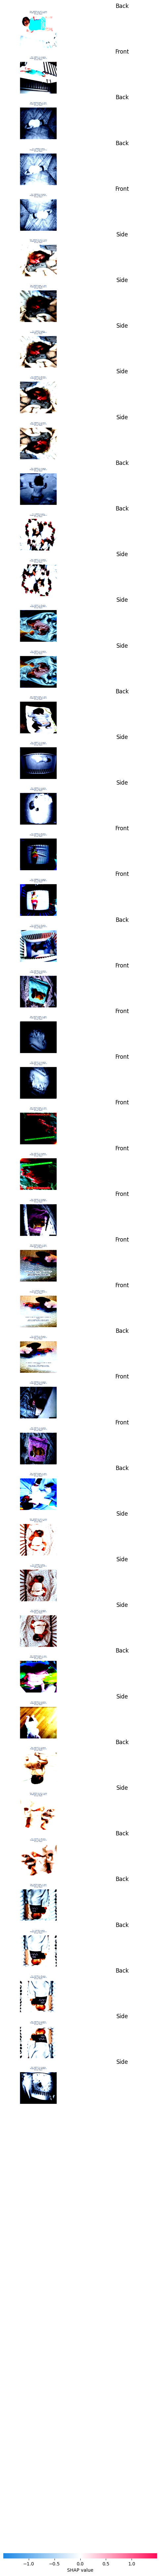

In [63]:
# 시각화
predicted_labels = np.array(predicted_labels).reshape(-1, 1)  # (batch_size, 1)
print(f"✅ Fixed Labels shape: {predicted_labels.shape}")  # (46, 1) 예상
shap.image_plot(shap_values_fixed, image_array_shap, labels=predicted_labels)

